<a href="https://colab.research.google.com/github/der-matt02/3D-Platform-Backend/blob/master/01_basicRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Basic Regresion

Importing useful libraries

In [37]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error
from scipy.ndimage import uniform_filter1d

The synthetic dataset corresponds to: $Y=XW+b+\eta$

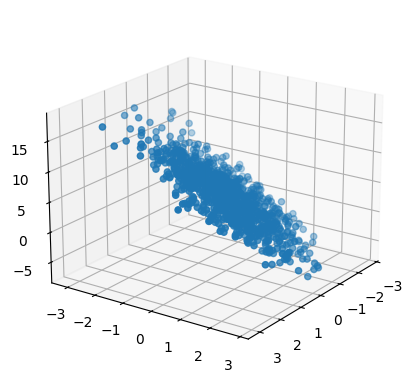

In [38]:
num_samples = 1000
Wt = np.array([[2], [-3.4]])
bt = 4.2

X = np.random.normal(size=(num_samples, Wt.size))
y = np.dot(X, Wt) + bt + np.random.normal(size=(num_samples,1))

ax = plt.axes(projection="3d")
ax.scatter3D(X[:,0], X[:,1], y[:,0])
ax.view_init(20, 35)

Dataset partitioning for training and validation

In [39]:
from sklearn.model_selection import train_test_split

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, y, test_size=0.3)

## Model creation

In [40]:
W = 0.01*np.random.normal(size=(Wt.size, 1))
b = 0

In [41]:
lr = 1e-2
loss = [];                      # tracking
for epoch in range(10):
    for i in range(Ytrain.size):
        input = Xtrain[i:i+1]
        output = Ytrain[i]
        y_hat = np.dot(input, W) + b
        error = y_hat - output
        loss.append(mean_squared_error(output, y_hat)/2)  # tracking
        gradW = input.T * error
        grabB = error
        W -= lr*gradW;
        b -= lr*grabB;

print("W =", W.T, "and b =", b)

W = [[ 2.08391988 -3.50417044]] and b = [[4.32899208]]


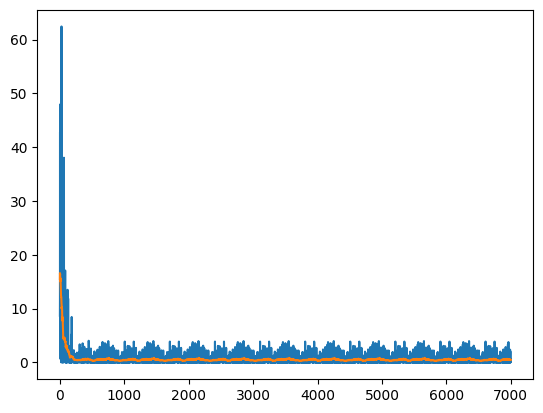

In [42]:
plt.plot(loss)
plt.plot(uniform_filter1d(loss, size=50));

---

## Model reset & training

Model reset

In [48]:
W = 0.01*np.random.normal(size=(Wt.size, 1))
b = 0

Model training

In [49]:
from sklearn.utils import gen_batches

lr = 0.01
loss = [];                                # tracking
for epoch in range(40):
    slices = gen_batches(Ytrain.size, 32)
    for s in slices:
        input = Xtrain[s]
        output = Ytrain[s]
        y_hat = np.dot(input, W) + b
        error = y_hat - output
        loss.append(mean_squared_error(output, y_hat)/2)  # tracking
        gradW = np.dot(input.T, error)
        grabB = np.mean(error)
        W -= lr*gradW;
        b -= lr*grabB;

print("W =", W.T, "and b =", b)

W = [[ 2.10103914 -3.50650188]] and b = 4.219613175678575


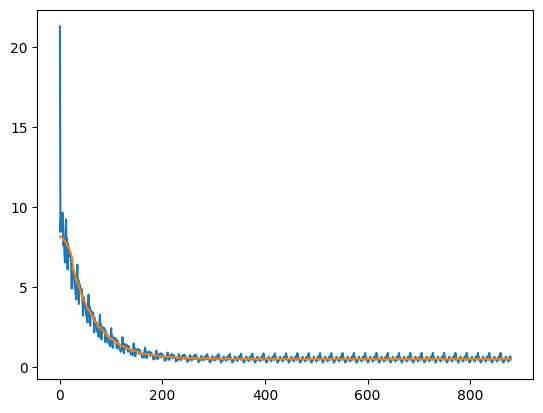

In [50]:
plt.plot(loss)
plt.plot(uniform_filter1d(loss, size=50));

Model evaluation

In [51]:
y_hat = np.dot(Xtest, W) + b
print("RMSE =", np.sqrt(mean_squared_error(Ytest, y_hat)))

RMSE = 0.9293331347523641


---


##**Assignment 1**: What are the best hyperparameters that minimize the RMSE in the last model? *(3 points)*

In [53]:
from sklearn.model_selection import KFold

# Rejilla pequeña
lr_list = [1e-3, 3e-3, 1e-2]
epochs_list = [10, 20, 40]
batch_list = [16, 32, 64]

# Asegurar forma columna en y
Ytrain_ = Ytrain if getattr(Ytrain, "ndim", 1) == 2 else Ytrain.reshape(-1, 1)
Ytest_  = Ytest  if getattr(Ytest,  "ndim", 1) == 2 else Ytest.reshape(-1, 1)

kf = KFold(n_splits=5, shuffle=True, random_state=42)

best_cfg = None
best_cv_rmse = float("inf")

for lr in lr_list:
    for epochs in epochs_list:
        for bs in batch_list:
            fold_rmses = []
            for tr_idx, va_idx in kf.split(Xtrain):
                Xtr, Xva = Xtrain[tr_idx], Xtrain[va_idx]
                Ytr, Yva = Ytrain_[tr_idx], Ytrain_[va_idx]

                # Inicialización reproducible
                rng = np.random.default_rng(42)
                n, d = Xtr.shape
                W = 0.01 * rng.normal(size=(d, 1))
                b = 0.0

                # Entrenamiento con mini-batches
                for _ in range(epochs):
                    idx = np.arange(n)
                    rng.shuffle(idx)
                    for start in range(0, n, bs):
                        batch_idx = idx[start:start+bs]
                        xb, yb = Xtr[batch_idx], Ytr[batch_idx]
                        yhat = xb @ W + b
                        err = yhat - yb
                        # Gradientes y paso
                        W -= lr * (xb.T @ err / len(batch_idx))
                        b -= lr * float(np.mean(err))

                # Validación del fold
                yva_hat = Xva @ W + b
                rmse_va = float(np.sqrt(mean_squared_error(Yva, yva_hat)))
                fold_rmses.append(rmse_va)

            mean_cv = float(np.mean(fold_rmses))
            if mean_cv < best_cv_rmse:
                best_cv_rmse = mean_cv
                best_cfg = {"lr": lr, "epochs": epochs, "batch_size": bs}

# Reentrenar en TODO el 70% con los mejores hiperparámetros
lr = best_cfg["lr"]; epochs = best_cfg["epochs"]; bs = best_cfg["batch_size"]

rng = np.random.default_rng(42)
n, d = Xtrain.shape
W = 0.01 * rng.normal(size=(d, 1))
b = 0.0

for _ in range(epochs):
    idx = np.arange(n)
    rng.shuffle(idx)
    for start in range(0, n, bs):
        batch_idx = idx[start:start+bs]
        xb, yb = Xtrain[batch_idx], Ytrain_[batch_idx]
        yhat = xb @ W + b
        err = yhat - yb
        W -= lr * (xb.T @ err / len(batch_idx))
        b -= lr * float(np.mean(err))

# Evaluación en TEST (30%)
ytest_hat = Xtest @ W + b
test_rmse = float(np.sqrt(mean_squared_error(Ytest_, ytest_hat)))

print("Mejores hiperparámetros:", best_cfg)
print("RMSE medio cross validation (CV) (5-fold):", round(best_cv_rmse, 6))
print("RMSE en test (30%):", round(test_rmse, 6))


Mejores hiperparámetros: {'lr': 0.01, 'epochs': 40, 'batch_size': 32}
RMSE medio cross validation (CV) (5-fold): 0.991382
RMSE en test (30%): 0.924738


---

##**Assignment 2**: Predict the value of houses in California using the dataset available in Scikit-learn. Print the lowest RMSE obtained with the test dataset. *(7 points)*

1.Cargar el dataset “California Housing” de scikit-learn.
  
Preprocesar (opcional pero recomendable: estandarizar features para modelos lineales).

Dividir 70/30 (train/test).

Entrenar modelo(s) en el 70% (puedes usar CV para elegir hiperparámetros).

Evaluar en el 30% test y imprimir el RMSE más bajo que logres.

### Exploracion de datos

- Importar librerias
- Cargar Dataset
- Exploracion de datos

In [13]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Cargar dataset y mostrar descripción oficial
dataset = datasets.fetch_california_housing(as_frame=True)
print(dataset.DESCR)  # descripción del dataset

In [15]:
# Pasar a pandas
df = dataset.frame.copy()
target_col = dataset.target.name
feature_cols = [c for c in df.columns if c != target_col]

In [ ]:
# Exploración rápida
print("\nShape:", df.shape)
print("Columnas:", list(df.columns))
print("\nFaltantes:\n", df.isna().sum())
display(df.describe().T)
display(df.head())

In [ ]:
# Distribución del target
plt.figure()
df[target_col].hist(bins=40)
plt.title(f"Distribución de {target_col}")
plt.xlabel(target_col)
plt.ylabel("Frecuencia")
plt.show()

In [ ]:
# Correlación simple con el target
corr = df.corr(numeric_only=True)[target_col].sort_values(ascending=False)
print("\nCorrelación con el target:")
print(corr)

### Division de Datos

In [19]:
# Particionamiento 70/30
from sklearn.model_selection import train_test_split
import numpy as np

X = dataset.data.to_numpy() # (n, 8)
y = dataset.target.to_numpy().ravel() # (n,), 1D

# Split reproducible 70/30 (test=30%)
Xtrain, Xtest, Ytrain, Ytest = train_test_split(
    X, y, test_size=0.30, random_state=42, shuffle=True)

print("Xtrain:", Xtrain.shape, "Ytrain:", Ytrain.shape)
print("Xtest :", Xtest.shape,  "Ytest :", Ytest.shape)


Xtrain: (14448, 8) Ytrain: (14448,)
Xtest : (6192, 8) Ytest : (6192,)


### Creacion del modelo

In [27]:
d = Xtrain.shape[1] # numero de features (entradas)
rng = np.random.default_rng(42) # semilla reproducible
W = (0.01 * rng.normal(size=(d, 1))).astype(np.float64) # pesos (d,1) pequeños
b = np.float64(0.0) # bias escalar

print("W shape:", W.shape, "| b:", b)

W shape: (8, 1) | b: 0.0


In [28]:
# Entrenamiento (mini-batch GD) y evaluación en test
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

# 1) Escalar features (fit SOLO en train, transform en test)
scaler = StandardScaler()
Xtrain_s = scaler.fit_transform(Xtrain)
Xtest_s = scaler.transform(Xtest)

# 2) Hiperparámetros prudentes
lr = 1e-3
epochs = 20
batch_size = 32

# 3) Preparar y como columna
Ytrain_col = Ytrain.reshape(-1, 1)

# 4) Mini-batch Gradient Descent (usa W, b existentes)
n = Xtrain_s.shape[0]
rng = np.random.default_rng(123)

for epoch in range(epochs):
    idx = rng.permutation(n)
    Xep = Xtrain_s[idx]
    Yep = Ytrain_col[idx]

    for start in range(0, n, batch_size):
        xb = Xep[start:start+batch_size] # (bs, d)
        yb = Yep[start:start+batch_size] # (bs, 1)

        yhat = np.dot(xb, W) + b # (bs, 1)
        err = yhat - yb # (bs, 1)

        # gradientes promedio por batch
        gradW = np.dot(xb.T, err) / len(xb) # (d, 1)
        gradb = float(err.mean()) # escalar

        # actualización
        W -= lr * gradW
        b -= lr * gradb

# 5) RMSE en test (lo que pide el assignment)
ytest_hat = np.dot(Xtest_s, W) + b
rmse_test = np.sqrt(mean_squared_error(Ytest, ytest_hat.ravel()))
print("RMSE en test:", round(rmse_test, 6))


RMSE en test: 0.743495


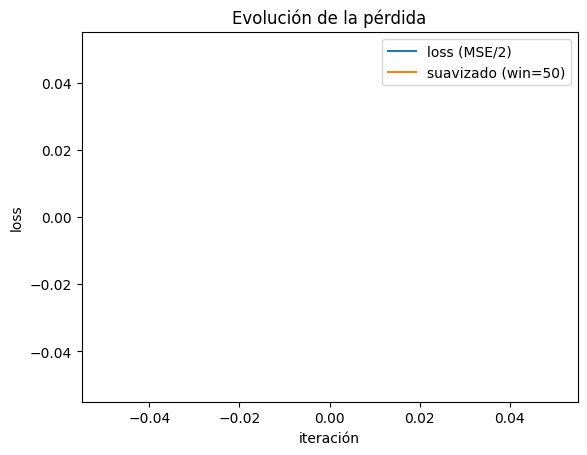

In [29]:
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss, label="loss (MSE/2)")
plt.plot(uniform_filter1d(loss, size=50), label="suavizado (win=50)")
plt.xlabel("iteración")
plt.ylabel("loss")
plt.title("Evolución de la pérdida")
plt.legend()
plt.show()


### Entrenamiento del Modelo

In [34]:
# Model reset / creación del modelo (W y b)
import numpy as np

d = Xtrain.shape[1]                 # nº de features
np.random.seed(42)                  # reproducible simple
W = 0.01 * np.random.normal(size=(d, 1))  # (d,1) pesos pequeños
b = 0.0                                    # bias escalar

print("W shape:", W.shape, " | b:", b)


W shape: (8, 1)  | b: 0.0


In [35]:
from sklearn.utils import gen_batches
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import numpy as np

# 1) Escalado (evita overflow)
scaler = StandardScaler()
Xtrain_s = scaler.fit_transform(Xtrain)
Xtest_s = scaler.transform(Xtest)

# 2) Hiperparámetros
lr = 1e-3
epochs = 40
batch = 32

# 3) Preparar shapes
Ytr = Ytrain.reshape(-1, 1)
n = Ytr.shape[0]

# 4) Entrenamiento mini-batch (estructura del profe)
loss = []
for epoch in range(epochs):
    for s in gen_batches(n, batch):
        x = Xtrain_s[s]
        y = Ytr[s]

        y_hat = np.dot(x, W) + b
        err   = y_hat - y

        # tracking de pérdida (MSE/2)
        loss.append(0.5 * mean_squared_error(y, y_hat))

        # gradientes promedio por batch
        gradW = np.dot(x.T, err) / len(x)
        gradB = float(err.mean())

        # actualización
        W -= lr * gradW
        b -= lr * gradB

print("W =", W.T, "and b =", b)

# 5) Evaluación (RMSE en test)
ytest_hat = np.dot(Xtest_s, W) + b
rmse_test = np.sqrt(mean_squared_error(Ytest, ytest_hat.ravel()))
print("RMSE en test:", round(rmse_test, 6))


W = [[ 0.84804912  0.15435136 -0.23639205  0.26985937  0.01156364 -0.04170908
  -0.65321746 -0.62443507]] and b = 2.0692639833305835
RMSE en test: 0.730709


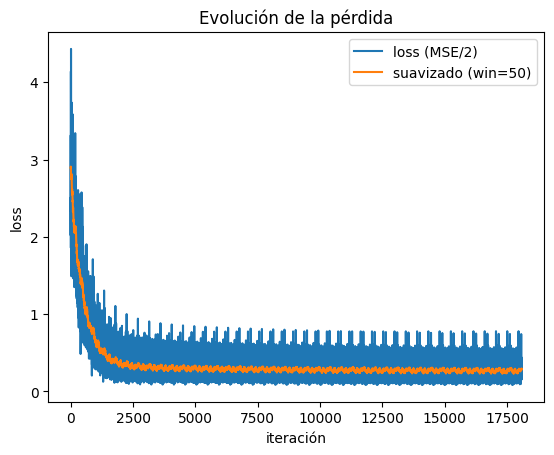

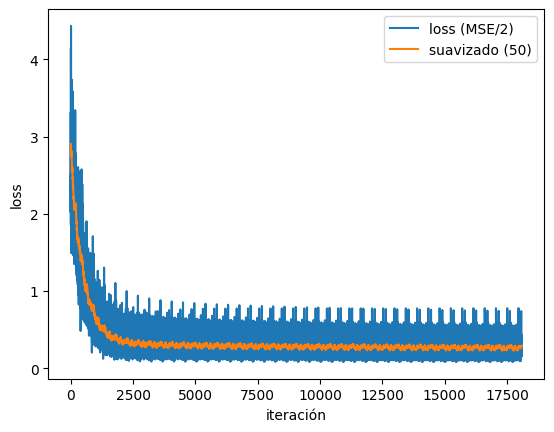

In [36]:
from scipy.ndimage import uniform_filter1d
import matplotlib.pyplot as plt

plt.figure()
plt.plot(loss, label="loss (MSE/2)")
plt.plot(uniform_filter1d(loss, size=50), label="suavizado (win=50)")
plt.xlabel("iteración")
plt.ylabel("loss")
plt.title("Evolución de la pérdida")
plt.legend()
plt.show()



plt.figure()
plt.plot(loss, label="loss (MSE/2)")
plt.plot(uniform_filter1d(loss, size=50), label="suavizado (50)")
plt.xlabel("iteración"); plt.ylabel("loss"); plt.legend(); plt.show()
